# MLP for complete TF
In this case, we are going to predict the complete TF function

In [597]:
import torch 
import pandas as pd 
import pickle
import numpy as np
import os
import sys 

from torch.utils.data import Dataset, DataLoader
from torch import nn


import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from tqdm import trange

sns.set_theme()

In [598]:
# Load data
freq_data = np.genfromtxt("TTF_Data_100.000_1.500_2.500.csv.csv")

# Load pickle
with open("TTF_data.pt", "rb") as f:
    TTF_data = pickle.load(f)

with open("Vs_values.pt", "rb") as f:
    Vs_data = pickle.load(f)

TTF_data = np.array(TTF_data)
Vs_data = np.array(Vs_data)

# Get Vs_data less than 800
index = Vs_data <= 1000
TTF_data = TTF_data[index]
Vs_data = Vs_data[index]

print(TTF_data.shape, Vs_data.shape)


(188, 256) (188,)


In [599]:
# Use only certain Vs
idx = np.random.choice(range(len(Vs_data)), 400)
TTF_values = TTF_data[idx]
Vs_values = Vs_data[idx]
print(TTF_values.shape, Vs_values.shape)

(400, 256) (400,)


In [600]:
# Normalize the data
def normalize_data(data, mean, std):
    return (data - mean) / std

def denormalize_data(data, mean, std):
    return data * std + mean

# Normalize the data
mean_Vs = Vs_values.mean()
std_Vs = Vs_values.std()
mean_TTF = TTF_values.mean()
std_TTF = TTF_values.std()

Vs_values = normalize_data(Vs_values, mean_Vs, std_Vs)
TTF_values = normalize_data(TTF_values, mean_TTF, std_TTF)

In [601]:
class TTFDataset(Dataset):
    def __init__(self, TTF_data, Vs_array):
        self.TTF_data = TTF_data
        self.Vs_array = Vs_array

    def __len__(self):
        return len(self.TTF_data)

    def __getitem__(self, idx):

        # Input 
        Vs = self.Vs_array[idx] * np.ones(30)
        input_data = Vs
        input_data = torch.tensor(input_data, dtype=torch.float32)

        # Target
        TTF = self.TTF_data[idx,:]
        target = torch.tensor(TTF, dtype=torch.float32)

        return input_data, target

In [602]:
# Create dataset
dataset = TTFDataset(TTF_values, Vs_values)

# Create dataloader
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
print("Number of samples: ", len(train_dataset), len(val_dataset), len(test_dataset))

# Create dataloader
i_batch_size = 200
train_loader = DataLoader(train_dataset, batch_size=i_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=i_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=i_batch_size, shuffle=True)
print("Number of batches: ", len(train_loader), len(val_loader), len(test_loader))



Number of samples:  320 40 40
Number of batches:  2 1 1


In [603]:
# Create Model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_layers, output_dim=1, activation=nn.ReLU, batch_norm=False):
        super(MLP, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.batch_norm = batch_norm
        self.activation = activation
        self.output_dim = output_dim

        # Input layer
        self.hidden_layers.append(nn.Linear(input_dim, hidden_dim))
        if self.batch_norm:
            self.hidden_layers.append(nn.BatchNorm1d(hidden_dim))

        # Hidden layers
        for _ in range(hidden_layers - 1):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
            if self.batch_norm:
                self.hidden_layers.append(nn.BatchNorm1d(hidden_dim))

        # Output layer
        self.out = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        for layer in self.hidden_layers:
            if isinstance(layer, nn.Linear):
                x = layer(x)
                x = self.activation()(x)
            elif isinstance(layer, nn.BatchNorm1d):
                x = layer(x)
        x = self.out(x)
        return x

In [604]:
# Define Transformer
class Transformer(nn.Module):
    def __init__(self, encoder_hidden_dim, encoder_hidden_size, decoder_hidden_dim, decoder_hidden_size, input_dim, output_dim, latent_dim):
        super(Transformer, self).__init__()

        self.encoder = MLP(input_dim, encoder_hidden_dim, encoder_hidden_size, latent_dim, batch_norm=True)
        self.decoder = MLP(latent_dim, decoder_hidden_dim, decoder_hidden_size, output_dim, batch_norm=True)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [605]:
model = Transformer(128, 5, 128, 5, 30, 256, 5)
loss_fn = nn.MSELoss()
X,y = next(iter(train_loader))
print(X.shape, y.shape)
pred = model(X)
assert pred.shape == y.shape , f"Expected shape {y.shape} but got {pred.shape}"
print("Loss: ", loss_fn(pred, y))

torch.Size([200, 30]) torch.Size([200, 256])
Loss:  tensor(1.3052, grad_fn=<MseLossBackward0>)


In [606]:
# Early stopping
class EarlyStopping():
    def __init__(self, patience=5, delta=0.0, progress_bar=None):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.progress_bar = progress_bar

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.progress_bar:
                self.progress_bar.set_postfix_str(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0
            if self.progress_bar:
                self.progress_bar.set_postfix_str('')

In [607]:
import torch
from tqdm import tqdm, trange
import torch.nn as nn
import numpy as np

def train(model, optimizer, scheduler, train_dataloader, validation_dataloader, loss_fn, epochs=100, device="cpu", patience=50):
    train_losses = []
    val_losses = []
    model.to(device)
    progress_bar = tqdm(range(epochs), desc="Training", unit="epoch")
    early_stopping = EarlyStopping(patience=patience, progress_bar=progress_bar)

    for epoch in progress_bar:
        model.train()
        train_loss = 0
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in validation_dataloader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                loss = loss_fn(y_pred, y)
                val_loss += loss.item()
        val_loss /= len(validation_dataloader)
        val_losses.append(val_loss)

        if early_stopping is not None:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

        if scheduler is not None:
            scheduler.step(val_loss)

        if epoch % 250 == 0:
            print(f"Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}, LR: {optimizer.param_groups[0]['lr']}")

        # Stop if loss is nan
        if np.isnan(train_loss) or np.isnan(val_loss):
            print("Loss is nan")
            break

    return train_losses, val_losses, model

In [608]:
# Define test function
def test(model, test_dataloader, loss_fn, device="cpu"):
    model.eval()
    test_loss = 0
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        test_loss += loss.item()
    test_loss /= len(test_dataloader)
    return test_loss

In [609]:
# Device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [610]:
# Model
model = Transformer(128, 3, 128, 3, 30, 256, 50)

# Xavier Glore initialization
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)

# Loss function - RMSE
def rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2))

loss_fn = rmse

In [611]:
# Optimizer with momentum NAG
#optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.5, weight_decay=0.01, nesterov=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, betas=(0.9, 0.999), weight_decay=0.01)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=0.01)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.9, eps=1e-08, weight_decay=0.01, momentum=0.9, centered=False)


# Scheduler with exponential decay
#scheduler = None
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=250, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-4, eps=1e-08)

In [612]:
# Train model
train_losses, val_losses, model = train(model, optimizer, scheduler, train_loader, val_loader, loss_fn, epochs=10000, device=device, patience=2000)

Training:   0%|          | 0/10000 [00:00<?, ?epoch/s]

Epoch 0, Train Loss: 1.2372008562088013, Val Loss: 0.9951125979423523, LR: 0.01


Training:   3%|▎         | 254/10000 [00:07<05:07, 31.74epoch/s, EarlyStopping counter: 14 out of 2000]

Epoch 250, Train Loss: 0.44263578951358795, Val Loss: 0.4926421642303467, LR: 0.01


Training:   5%|▌         | 506/10000 [00:14<05:38, 28.02epoch/s, EarlyStopping counter: 104 out of 2000]

Epoch 500, Train Loss: 0.5944112688302994, Val Loss: 0.584804892539978, LR: 0.01


Training:   8%|▊         | 757/10000 [00:31<04:54, 31.34epoch/s, EarlyStopping counter: 9 out of 2000]  

Epoch 750, Train Loss: 0.2999540939927101, Val Loss: 0.37788334488868713, LR: 0.01


Training:  10%|█         | 1002/10000 [00:51<12:50, 11.67epoch/s, EarlyStopping counter: 14 out of 2000]

Epoch 1000, Train Loss: 0.43291042745113373, Val Loss: 0.39918598532676697, LR: 0.01


Training:  13%|█▎        | 1252/10000 [01:14<11:27, 12.72epoch/s, EarlyStopping counter: 217 out of 2000]

Epoch 1250, Train Loss: 0.3098501116037369, Val Loss: 0.37255850434303284, LR: 0.01


Training:  15%|█▌        | 1502/10000 [01:36<12:15, 11.55epoch/s, EarlyStopping counter: 75 out of 2000] 

Epoch 1500, Train Loss: 0.3580806404352188, Val Loss: 0.33877262473106384, LR: 0.005


Training:  18%|█▊        | 1752/10000 [01:59<12:01, 11.44epoch/s, EarlyStopping counter: 325 out of 2000]

Epoch 1750, Train Loss: 0.22461774200201035, Val Loss: 0.33830446004867554, LR: 0.0025


Training:  20%|██        | 2002/10000 [02:22<11:46, 11.31epoch/s, EarlyStopping counter: 11 out of 2000] 

Epoch 2000, Train Loss: 0.2702886611223221, Val Loss: 0.27793052792549133, LR: 0.0025


Training:  23%|██▎       | 2254/10000 [02:44<08:58, 14.37epoch/s, EarlyStopping counter: 61 out of 2000] 

Epoch 2250, Train Loss: 0.22798193246126175, Val Loss: 0.25031277537345886, LR: 0.0025


Training:  25%|██▌       | 2503/10000 [02:56<03:36, 34.69epoch/s, EarlyStopping counter: 124 out of 2000]

Epoch 2500, Train Loss: 0.19544020295143127, Val Loss: 0.3488960862159729, LR: 0.0025


Training:  28%|██▊       | 2757/10000 [03:03<02:54, 41.47epoch/s, EarlyStopping counter: 213 out of 2000]

Epoch 2750, Train Loss: 0.1953124925494194, Val Loss: 0.27176904678344727, LR: 0.0025


Training:  30%|███       | 3002/10000 [03:14<09:10, 12.71epoch/s, EarlyStopping counter: 118 out of 2000]

Epoch 3000, Train Loss: 0.2398730218410492, Val Loss: 0.2120427042245865, LR: 0.00125


Training:  33%|███▎      | 3252/10000 [03:34<08:51, 12.69epoch/s, EarlyStopping counter: 148 out of 2000]

Epoch 3250, Train Loss: 0.18079932779073715, Val Loss: 0.22479379177093506, LR: 0.00125


Training:  35%|███▌      | 3502/10000 [03:54<08:26, 12.84epoch/s, EarlyStopping counter: 109 out of 2000]

Epoch 3500, Train Loss: 0.19350145757198334, Val Loss: 0.23748765885829926, LR: 0.000625


Training:  38%|███▊      | 3752/10000 [04:14<08:13, 12.66epoch/s, EarlyStopping counter: 359 out of 2000]

Epoch 3750, Train Loss: 0.20923638343811035, Val Loss: 0.21946606040000916, LR: 0.0003125


Training:  40%|████      | 4002/10000 [04:34<08:37, 11.59epoch/s, EarlyStopping counter: 609 out of 2000]

Epoch 4000, Train Loss: 0.2192849963903427, Val Loss: 0.20525939762592316, LR: 0.00015625


Training:  43%|████▎     | 4252/10000 [04:54<07:15, 13.20epoch/s, EarlyStopping counter: 859 out of 2000]

Epoch 4250, Train Loss: 0.15517663955688477, Val Loss: 0.19501055777072906, LR: 0.0001


Training:  45%|████▌     | 4502/10000 [05:14<07:03, 12.98epoch/s, EarlyStopping counter: 1109 out of 2000]

Epoch 4500, Train Loss: 0.1920476257801056, Val Loss: 0.2012951672077179, LR: 0.0001


Training:  48%|████▊     | 4752/10000 [05:33<06:47, 12.88epoch/s, EarlyStopping counter: 1359 out of 2000]

Epoch 4750, Train Loss: 0.15526262670755386, Val Loss: 0.20387311279773712, LR: 0.0001


Training:  50%|█████     | 5002/10000 [05:53<06:55, 12.03epoch/s, EarlyStopping counter: 1609 out of 2000]

Epoch 5000, Train Loss: 0.2865647152066231, Val Loss: 0.20496876537799835, LR: 0.0001


Training:  53%|█████▎    | 5252/10000 [06:13<06:03, 13.07epoch/s, EarlyStopping counter: 1859 out of 2000]

Epoch 5250, Train Loss: 0.18409882485866547, Val Loss: 0.20442137122154236, LR: 0.0001


Training:  55%|█████▌    | 5502/10000 [06:33<07:17, 10.28epoch/s, EarlyStopping counter: 146 out of 2000] 

Epoch 5500, Train Loss: 0.2216811403632164, Val Loss: 0.2087378054857254, LR: 0.0001


Training:  58%|█████▊    | 5752/10000 [06:53<05:30, 12.85epoch/s, EarlyStopping counter: 149 out of 2000]

Epoch 5750, Train Loss: 0.16478066891431808, Val Loss: 0.2116205245256424, LR: 0.0001


Training:  60%|██████    | 6002/10000 [07:13<05:16, 12.64epoch/s, EarlyStopping counter: 80 out of 2000] 

Epoch 6000, Train Loss: 0.20061013847589493, Val Loss: 0.18986579775810242, LR: 0.0001


Training:  63%|██████▎   | 6252/10000 [07:33<04:50, 12.88epoch/s, EarlyStopping counter: 330 out of 2000]

Epoch 6250, Train Loss: 0.2753576561808586, Val Loss: 0.18911200761795044, LR: 0.0001


Training:  65%|██████▌   | 6502/10000 [07:53<04:30, 12.91epoch/s, EarlyStopping counter: 580 out of 2000]

Epoch 6500, Train Loss: 0.17614776641130447, Val Loss: 0.19203875958919525, LR: 0.0001


Training:  68%|██████▊   | 6752/10000 [08:12<04:20, 12.47epoch/s, EarlyStopping counter: 830 out of 2000]

Epoch 6750, Train Loss: 0.15886938571929932, Val Loss: 0.20447613298892975, LR: 0.0001


Training:  70%|███████   | 7002/10000 [08:32<03:48, 13.12epoch/s, EarlyStopping counter: 1080 out of 2000]

Epoch 7000, Train Loss: 0.16083503514528275, Val Loss: 0.19614163041114807, LR: 0.0001


Training:  73%|███████▎  | 7252/10000 [08:52<03:33, 12.88epoch/s, EarlyStopping counter: 1330 out of 2000]

Epoch 7250, Train Loss: 0.15541356056928635, Val Loss: 0.2053041309118271, LR: 0.0001


Training:  75%|███████▌  | 7502/10000 [09:12<03:20, 12.45epoch/s, EarlyStopping counter: 73 out of 2000]  

Epoch 7500, Train Loss: 0.24197303503751755, Val Loss: 0.20910893380641937, LR: 0.0001


Training:  78%|███████▊  | 7752/10000 [09:32<02:49, 13.25epoch/s, EarlyStopping counter: 323 out of 2000]

Epoch 7750, Train Loss: 0.14507808536291122, Val Loss: 0.2084679901599884, LR: 0.0001


Training:  80%|████████  | 8002/10000 [09:51<02:31, 13.15epoch/s, EarlyStopping counter: 573 out of 2000]

Epoch 8000, Train Loss: 0.13889645785093307, Val Loss: 0.21121510863304138, LR: 0.0001


Training:  83%|████████▎ | 8252/10000 [10:11<02:21, 12.32epoch/s, EarlyStopping counter: 823 out of 2000]

Epoch 8250, Train Loss: 0.1686358079314232, Val Loss: 0.21228106319904327, LR: 0.0001


Training:  85%|████████▌ | 8502/10000 [10:31<01:53, 13.20epoch/s, EarlyStopping counter: 1073 out of 2000]

Epoch 8500, Train Loss: 0.1604725867509842, Val Loss: 0.20961540937423706, LR: 0.0001


Training:  88%|████████▊ | 8755/10000 [10:50<00:40, 30.74epoch/s, EarlyStopping counter: 1328 out of 2000]

Epoch 8750, Train Loss: 0.19721725583076477, Val Loss: 0.1914629191160202, LR: 0.0001


Training:  90%|█████████ | 9005/10000 [10:57<00:27, 35.72epoch/s, EarlyStopping counter: 1578 out of 2000]

Epoch 9000, Train Loss: 0.14932500943541527, Val Loss: 0.19728751480579376, LR: 0.0001


Training:  93%|█████████▎| 9255/10000 [11:05<00:18, 39.89epoch/s, EarlyStopping counter: 1829 out of 2000]

Epoch 9250, Train Loss: 0.16595394164323807, Val Loss: 0.189249649643898, LR: 0.0001


Training:  94%|█████████▍| 9429/10000 [11:10<00:40, 14.07epoch/s, EarlyStopping counter: 2000 out of 2000]

Early stopping


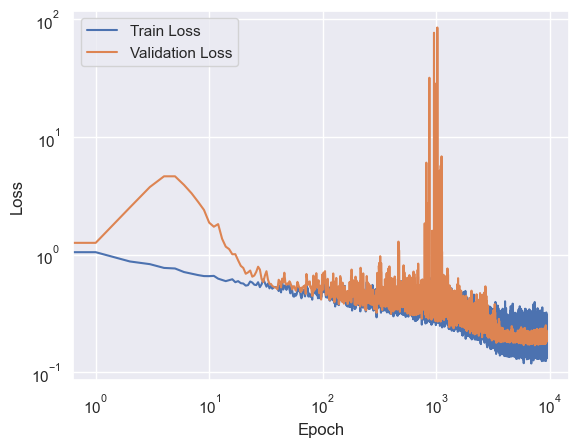

In [613]:
# Plot losses
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [614]:
# Test the model
test_loss = test(model, test_loader, loss_fn, device=device)
print("Test loss: ", test_loss)

Test loss:  0.23602239787578583


In [615]:
# Predict and plot
model.eval()
predictions = []
target = []
Vs_target = []
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        predictions.append(y_pred.cpu().numpy())
        target.append(y.cpu().numpy()) 
        Vs_target.append(X[:, 0].cpu().numpy())

predictions = np.concatenate(predictions)
target = np.concatenate(target)
Vs_target = np.concatenate(Vs_target)

# Denormalize
Vs_target = denormalize_data(Vs_target, mean_Vs, std_Vs)
predictions = denormalize_data(predictions, mean_TTF, std_TTF)
target = denormalize_data(target, mean_TTF, std_TTF)

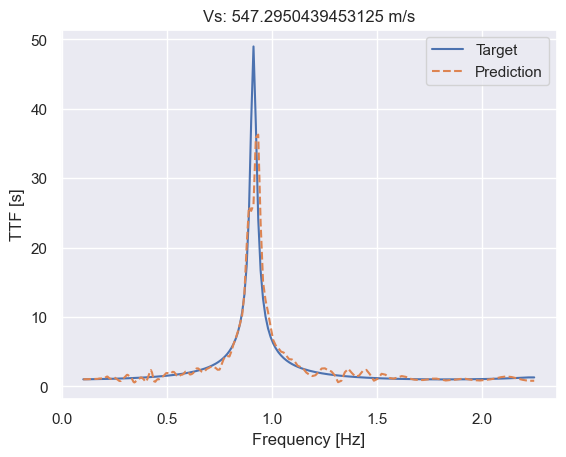

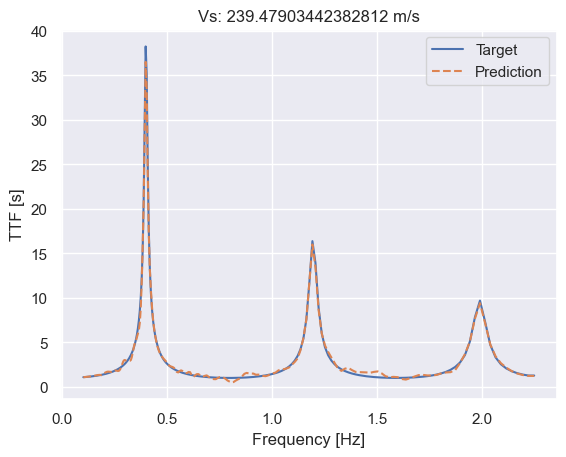

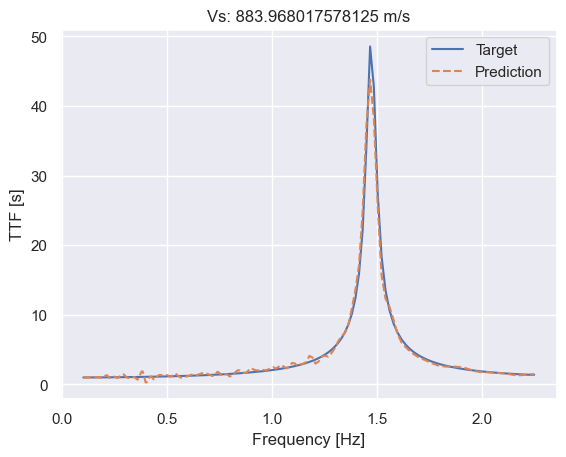

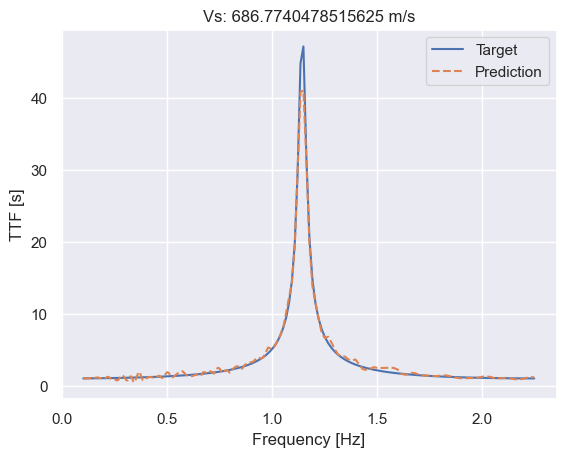

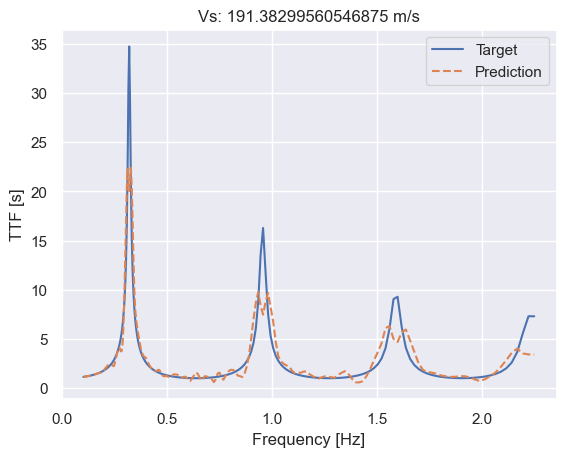

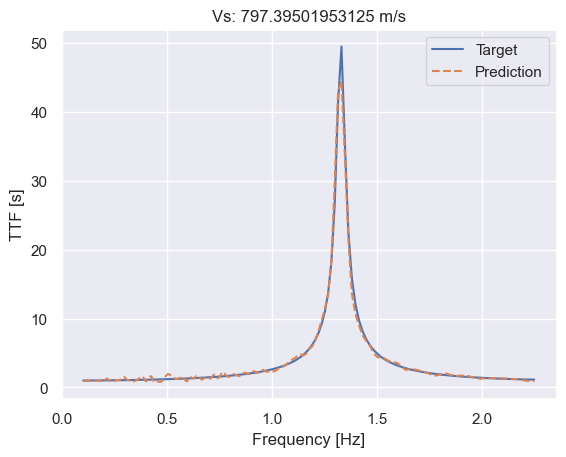

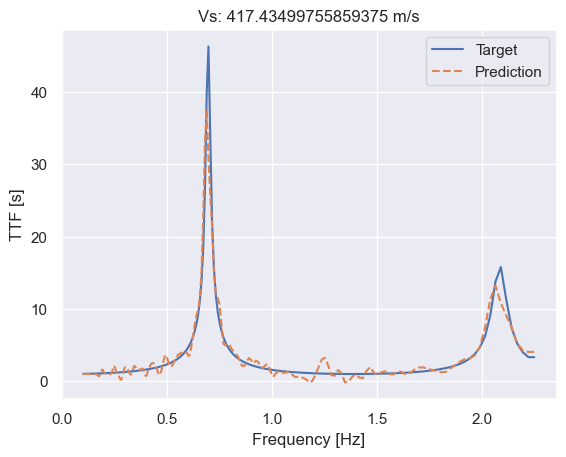

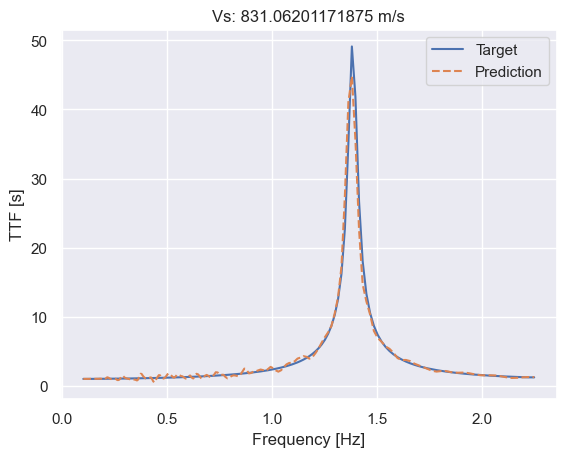

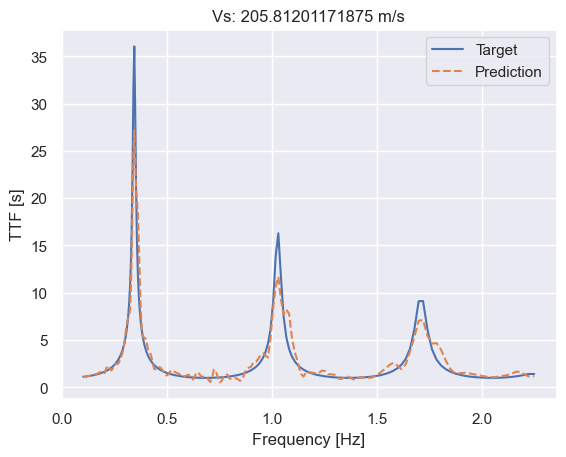

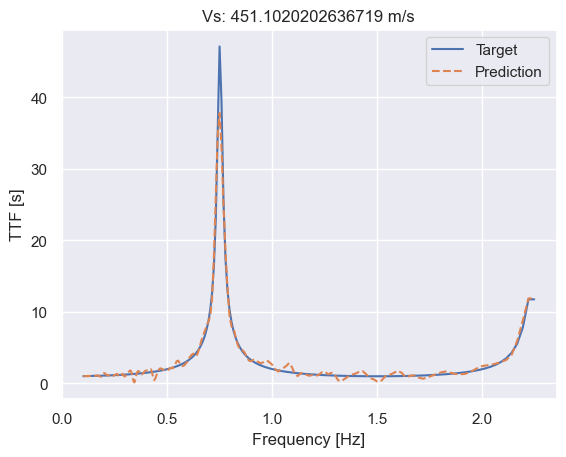

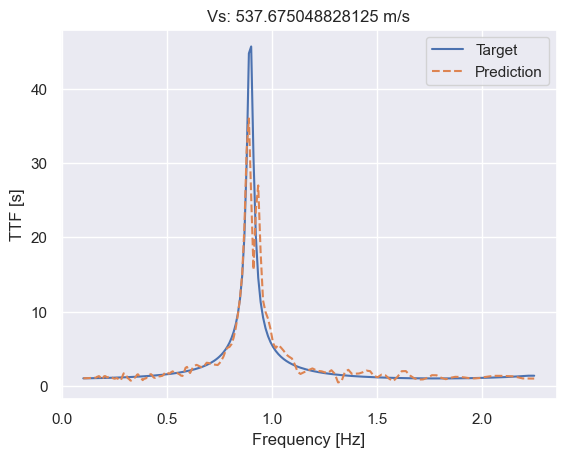

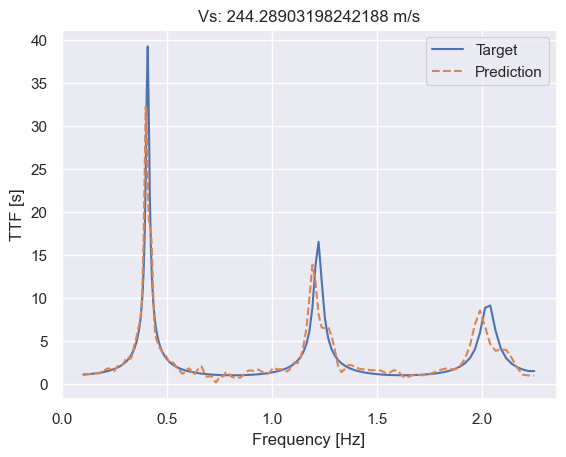

In [616]:
for idx in range(target.shape[0]):
    plt.plot(freq_data,target[idx], label="Target")
    plt.plot(freq_data,predictions[idx], label="Prediction", linestyle="--")
    plt.legend()
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("TTF [s]")
    plt.title(f"Vs: {Vs_target[idx]} m/s")
    plt.show()
    if idx > 10:
        break

In [617]:
# Save model
torch.save(model.state_dict(), "transformer_model.pt")